In [32]:
# 导入包
import numpy as np
import mne
import os
from mne.preprocessing import ICA
from antio import read_cnt
from antio.parser import read_triggers
from mne.io import read_raw_ant
from eeglabio.utils import export_mne_raw
import matplotlib.pyplot as plt
%matplotlib qt 

In [2]:
# 数据载入（念通智能版）
input_data_path = r"D:\Documents\EEG\standard-EEG\data\record重测_20250408105221.bdf"  # 修改：脑电数据位置
raw = mne.io.read_raw_bdf(input_data_path, preload=True)  # EEG为读入进来的脑电数据

Extracting EDF parameters from D:\Documents\EEG\standard-EEG\data\record重测_20250408105221.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4393999  =      0.000 ...  4393.999 secs...


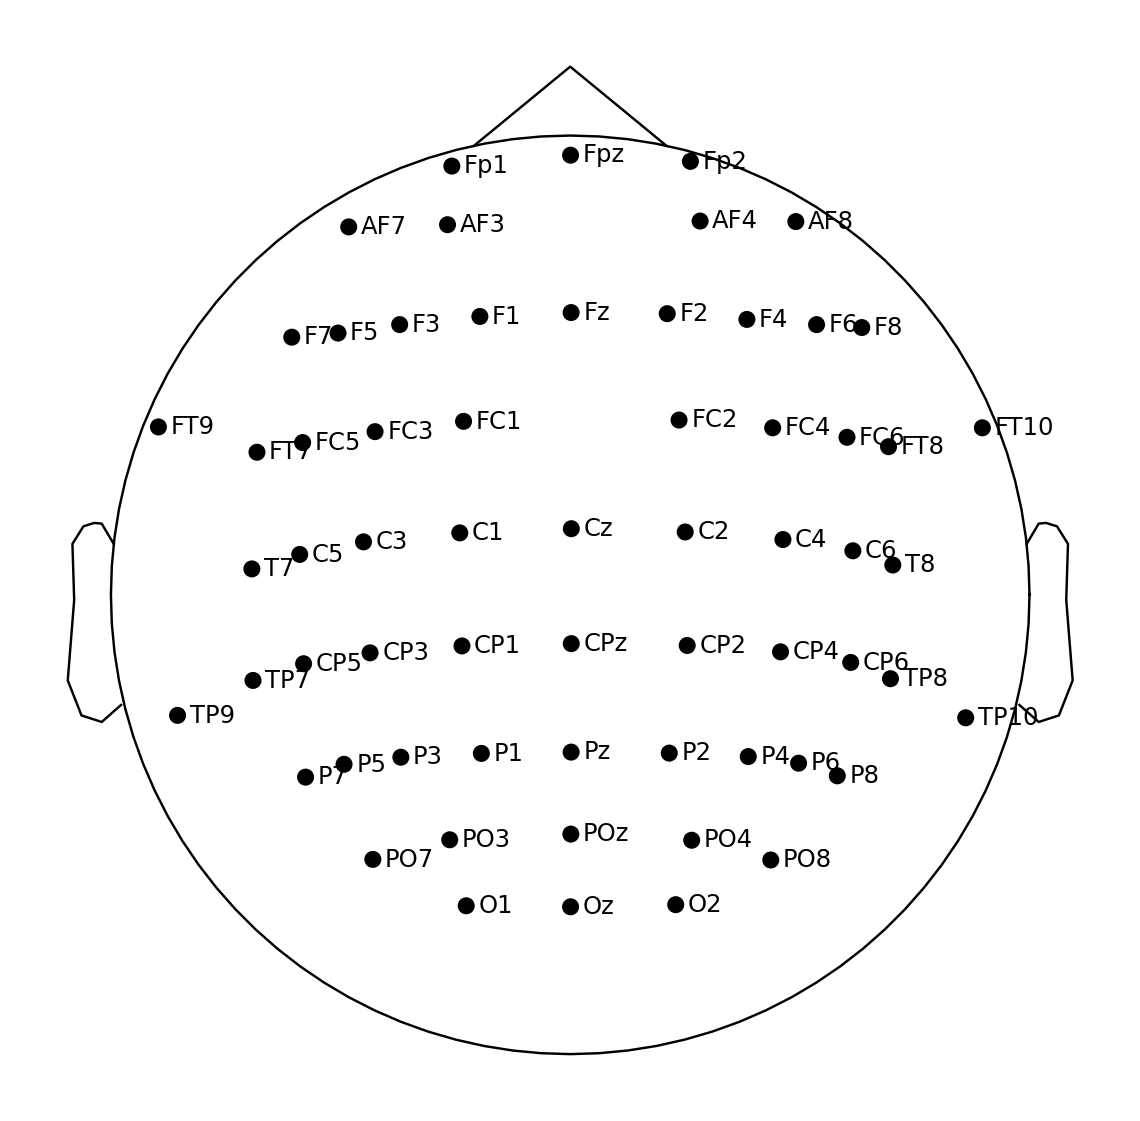

In [3]:
# 对脑电数据的电极位置进行定位（念通智能）
channel_montage = mne.channels.read_custom_montage(r"D:\Documents\EEG\standard-EEG\location_file\standard_1005.elc")  # 修改： .elc为电极定位文件（念通智能64导），需根据实际情况修改该文件位置
raw.drop_channels(['I0'])  # 去除眼睛下方的电极
raw.set_montage(channel_montage)  # 将电极位置坐标赋予脑电数据各通道
raw.plot_sensors(kind='topomap', show_names=True)  # 查看电极位置（可注释）

Reading ANT file D:\Documents\EEG\split_EEG\data\fazhan_ban_2025-01-08_19-24-01.cnt
All 63 EEG channels are referenced to CPz.
Reading 0 ... 2091806  =      0.000 ...  2091.806 secs...
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']


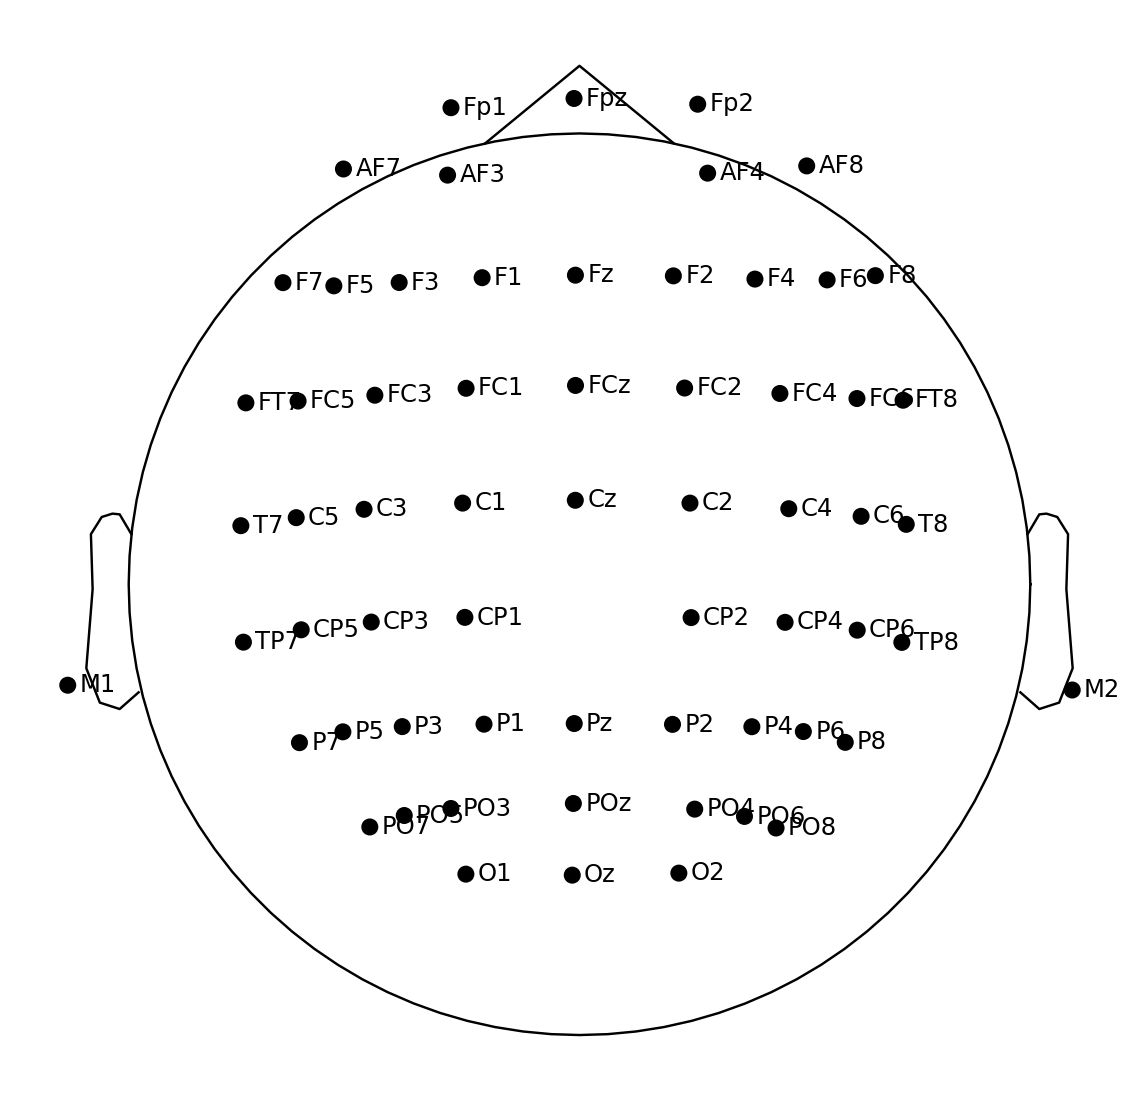

In [54]:
# 数据载入与（Ant设备版）
input_data_path = r"D:\Documents\EEG\split_EEG\data\fazhan_ban_2025-01-08_19-24-01.cnt"  # 修改：脑电数据位置
raw = read_raw_ant(input_data_path, eog=r"EOG", preload=True)
raw.pick("eeg").set_montage("standard_1005")
raw.plot_sensors(kind='topomap', show_names=True)  # 查看电极位置（可注释）

In [34]:
# 查看脑电数据并先删除实验开始前后不稳定的数据
fig = raw.plot(block=True)  # 可视化脑电信号

Channels marked as bad:
none


In [7]:
# 查看脑电数据并先删除实验开始前后不稳定的数据
EEG = raw.copy().crop(tmin=0, tmax=raw.times[-1])  # 修改：脑电数据截取时段
fig_after = EEG.plot(block=True)  # 可视化脑电信号

Channels marked as bad:
none


In [45]:
# 如果不进行上一步操作
EEG = raw

In [46]:
# 滤波
EEG.notch_filter(50)  # 陷波滤波，去除工频干扰50Hz
EEG.filter(l_freq=0.1, h_freq=None)  # 修改：高通滤波，保留大于0.1Hz的波
EEG.filter(l_freq=None, h_freq=100)  # 修改：低通滤波，保留小于100Hz的波

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 133 samples (0.133 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


<RawANT | fazhan_ban_2025-01-08_19-24-01.cnt, 63 x 2091807 (2091.8 s), ~1005.5 MiB, data loaded>

In [47]:
# 剔除坏导 （Lof算法寻找坏导）
bad_channels = mne.preprocessing.find_bad_channels_lof(EEG, threshold=2)  # 设置threshold，超参数，数值越小越严格

LOF: Detected bad channel(s): ['M1']


In [48]:
# 剔除坏导 + 插值坏导
EEG.info['bads'] = bad_channels
EEG = EEG.interpolate_bads(reset_bads=True)  # 插值坏导

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.1 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 1 sensors


In [11]:
# 降采样
EEG.resample(sfreq=500)  # 降采样500HZ

<RawEDF | record重测_20250408105221.bdf, 63 x 2197000 (4394.0 s), ~1.03 GiB, data loaded>

Channels marked as bad:
none


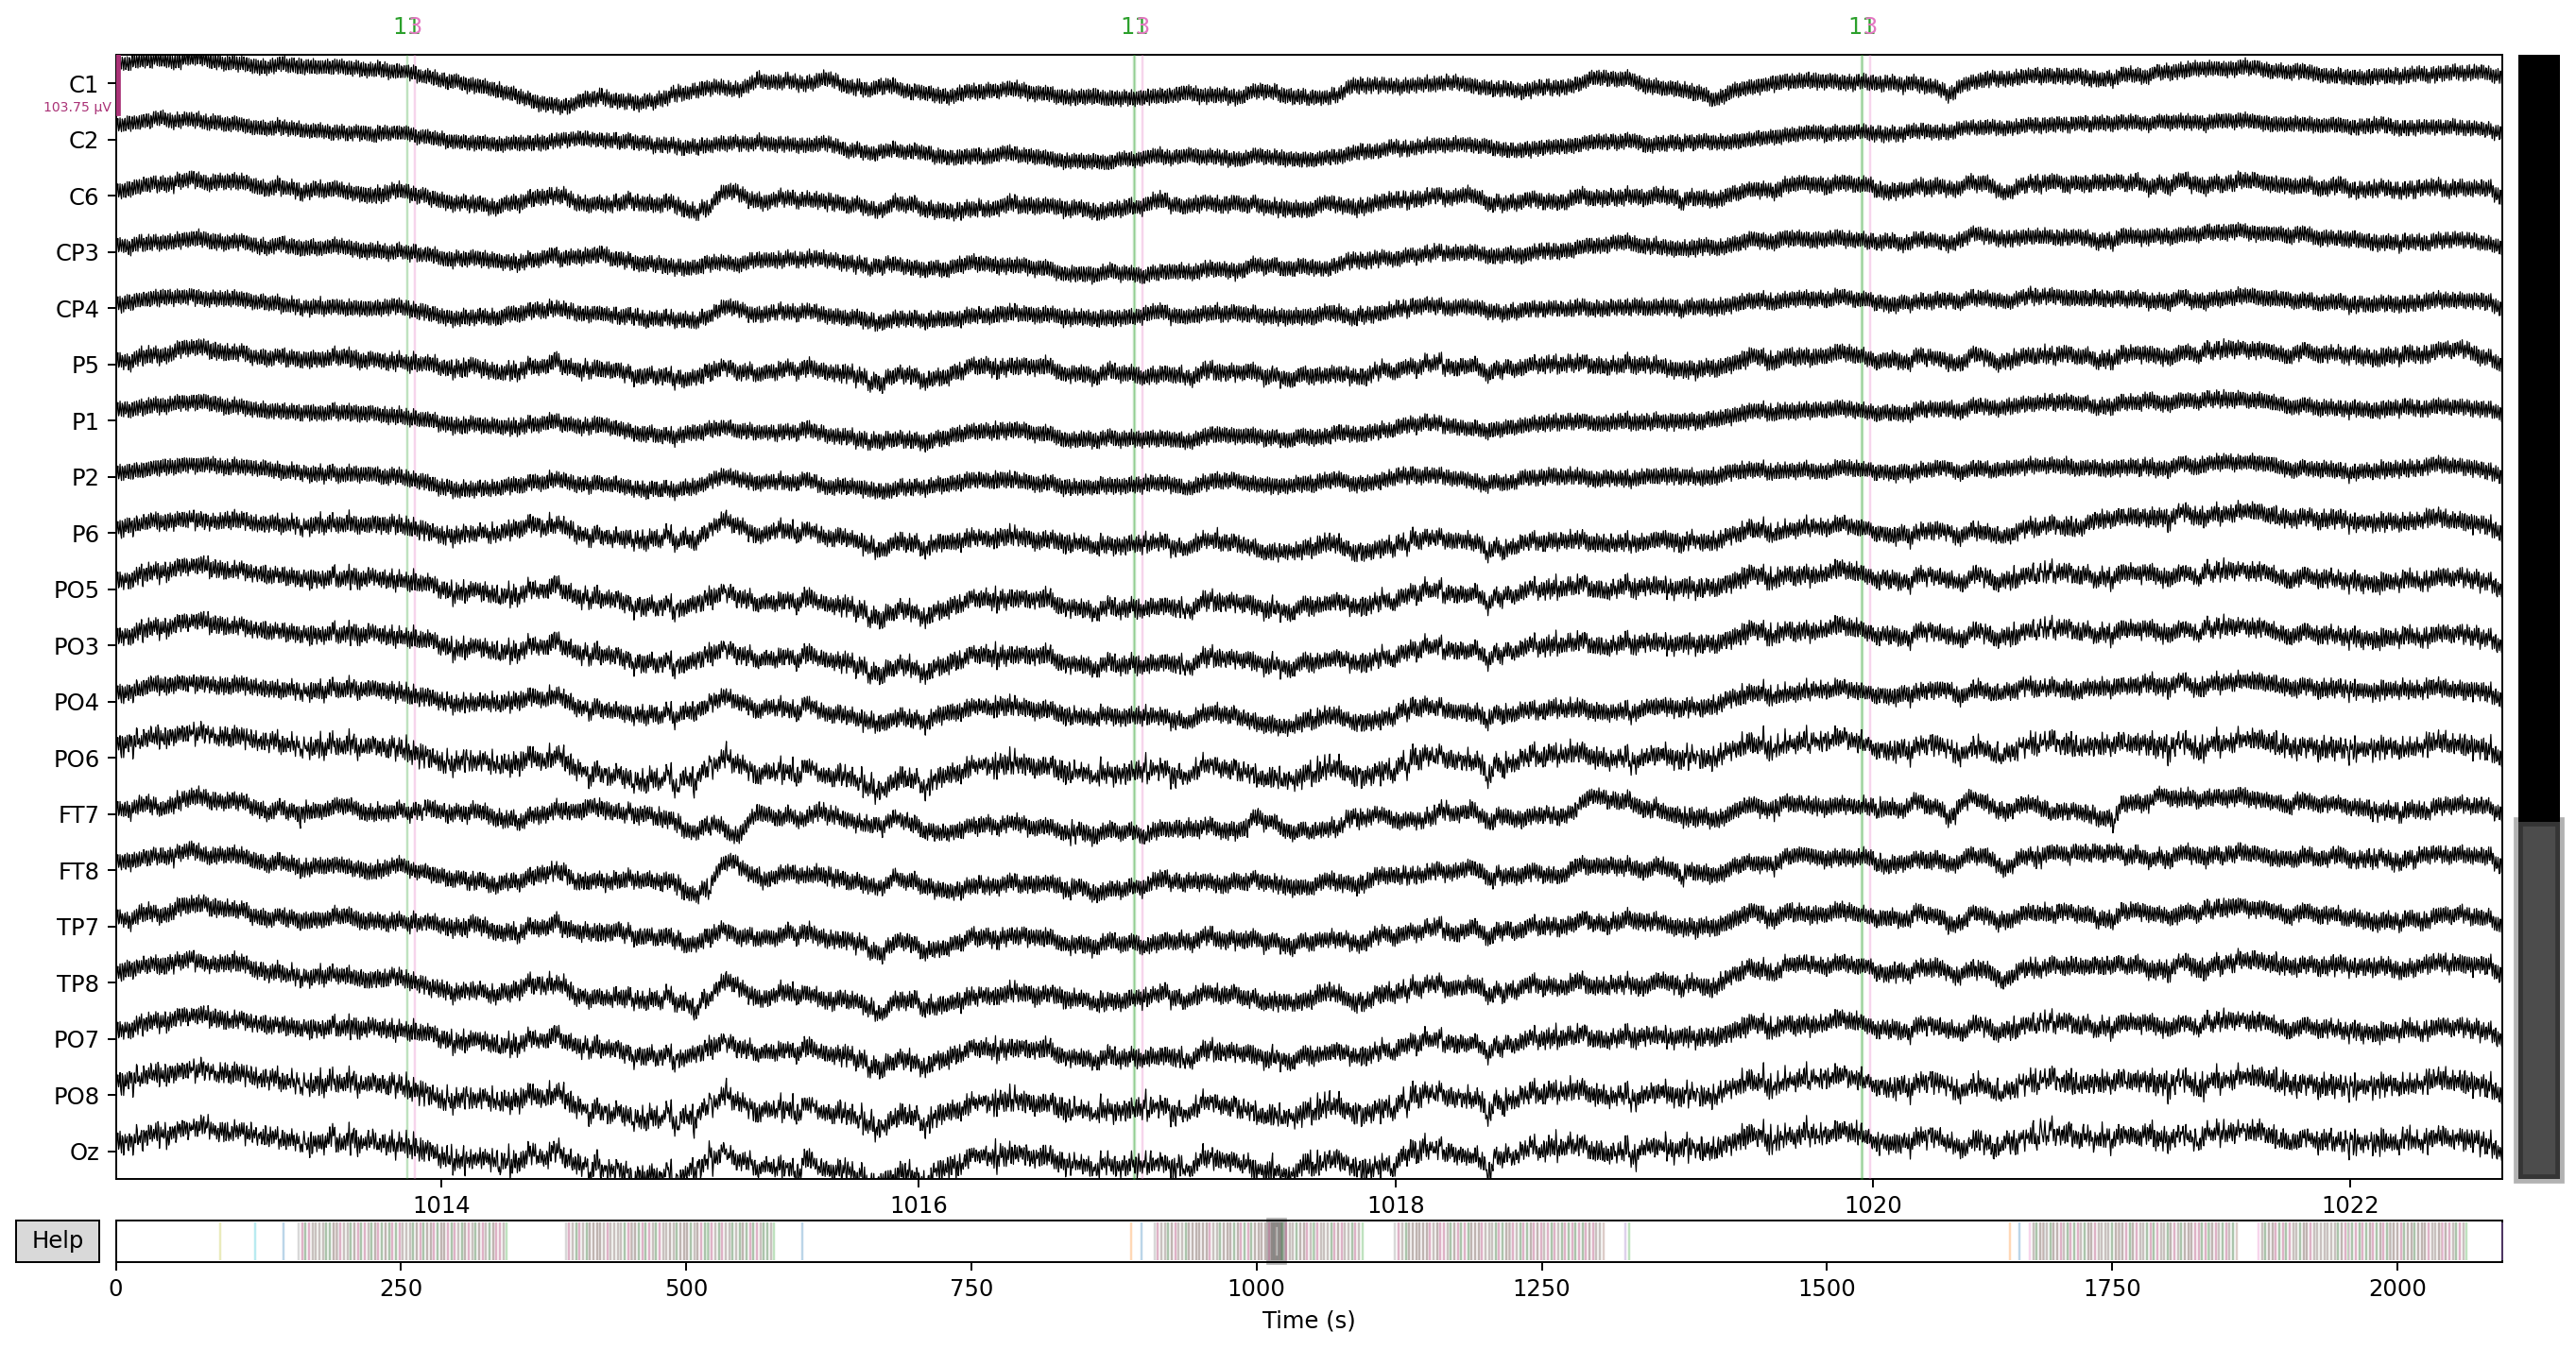

In [49]:
# #设置重参考
EEG.plot(block=True)

In [12]:
# #设置重参考
EEG.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | record重测_20250408105221.bdf, 63 x 2197000 (4394.0 s), ~1.03 GiB, data loaded>

In [13]:
# 剔除坏段:通过annotation对数据进行分段，并根据峰峰值拒绝某些段
# 查看数据中的marker
events, event_id = mne.events_from_annotations(EEG)
print(events)
print(event_id)


Used Annotations descriptions: [np.str_('T100'), np.str_('T101'), np.str_('T102'), np.str_('T103'), np.str_('T104'), np.str_('T105'), np.str_('T106'), np.str_('T107'), np.str_('T108'), np.str_('T109'), np.str_('T110'), np.str_('T111'), np.str_('T112'), np.str_('T120'), np.str_('T121'), np.str_('T122'), np.str_('T48'), np.str_('T49'), np.str_('T97'), np.str_('T98'), np.str_('T99')]
[[  36038       0      17]
 [ 146842       0      18]
 [ 148364       0       7]
 ...
 [2125654       0      15]
 [2126847       0       5]
 [2127284       0      15]]
{np.str_('T100'): 1, np.str_('T101'): 2, np.str_('T102'): 3, np.str_('T103'): 4, np.str_('T104'): 5, np.str_('T105'): 6, np.str_('T106'): 7, np.str_('T107'): 8, np.str_('T108'): 9, np.str_('T109'): 10, np.str_('T110'): 11, np.str_('T111'): 12, np.str_('T112'): 13, np.str_('T120'): 14, np.str_('T121'): 15, np.str_('T122'): 16, np.str_('T48'): 17, np.str_('T49'): 18, np.str_('T97'): 19, np.str_('T98'): 20, np.str_('T99'): 21}


In [ ]:
# 删除无用marker
del_arr = ['boundary', 'S 10', 'S 11', 'S 12']
for i in del_arr:
    event_id.pop(i, None)
    

In [14]:
# 按剩余marker分段并进行基线校准，基线范围可设定baseline，分段时间可设定（基于marker时刻），根据峰峰值200uV拒绝坏段
epochs = mne.Epochs(EEG, events, event_id, preload=True, tmin=-0.5, tmax=2, baseline=[-0.2, 0], reject=dict(eeg=200e-6))

Not setting metadata
2402 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2402 events and 1251 original time points ...
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'F2', 'F8', 'FT10', 'FT8', 'FC6', 'Cz', 'C2', 'T8', 'TP10', 'TP8', 'CP4', 'P4', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Fp1', 'AF7', 'F7', 'F5', 'FC3', 'FC5', 'FT7', 'FT9', 'T7', 'C3', 'CP3', 'TP7', 'TP9', 'P7', 'P5', 'P3', 'POz', 'PO3', 'PO7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F6', 'TP10', 'TP8', 'F7', 'FT9', 'T7', 'TP7', 'TP9']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F6', 'F8', 'FT10', 'FT8', 'T8', 'TP10', 'TP8', 'O2', 'F7', 'FC1', 'FT7', 'FT9', 'T7', 'TP9', 'PO3', 'PO7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['AF8', 'F8', 'FT10', 'FT8', 'T8', 'TP10', 'O2', 'F7', 'FT7', 'FT9', 'T7', 'TP9', 'PO7', 'Oz']
    Rejecting  epoch based on EEG : ['T8']


In [16]:
# 分段脑电 去伪迹 ICA
ica = ICA(n_components=30,  max_iter='auto')
ica.fit(epochs)
ica.plot_sources(epochs, show=True)
ica.plot_components()

Fitting ICA to data using 63 channels (please be patient, this may take a while)


C:\Users\Fang Yixin\AppData\Local\Temp\ipykernel_33676\1885244174.py:3: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 30 components
Fitting ICA took 211.5s.
Not setting metadata
1394 matching events found
No baseline correction applied
0 projection items activated


C:\Users\Fang Yixin\AppData\Local\Temp\ipykernel_33676\1885244174.py:4: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ica.plot_sources(epochs, show=True)


[<MNEFigure size 1706.25x1692.25 with 20 Axes>,
 <MNEFigure size 1706.25x868 with 10 Axes>]

In [17]:
# ICA 自动寻找肌电
muscle_idx_auto, scores = ica.find_bads_muscle(EEG)
ica.plot_scores(scores, exclude=muscle_idx_auto)  # 输出每一个成分被判断为肌电的分数
print(f"Automatically found muscle artifact ICA components: {muscle_idx_auto}")  # 输出肌电伪迹的成分号

Effective window size : 4.096 (s)
Automatically found muscle artifact ICA components: [5, 6, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29]


In [18]:
# ICA 自动寻找眼电
eog_indices, eog_scores = ica.find_bads_eog(EEG, ch_name='Fpz')  # 设置伪眼电通道 ‘FPz’
print(f"Automatically found eye artifact ICA components: {eog_indices}")

Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)
Automatically found eye artifact ICA components: [np.int64(0)]


Applying ICA to Epochs instance


C:\Users\Fang Yixin\AppData\Local\Temp\ipykernel_33676\1240724936.py:3: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (30 components)
    Zeroing out 10 ICA components
    Projecting back using 63 PCA components


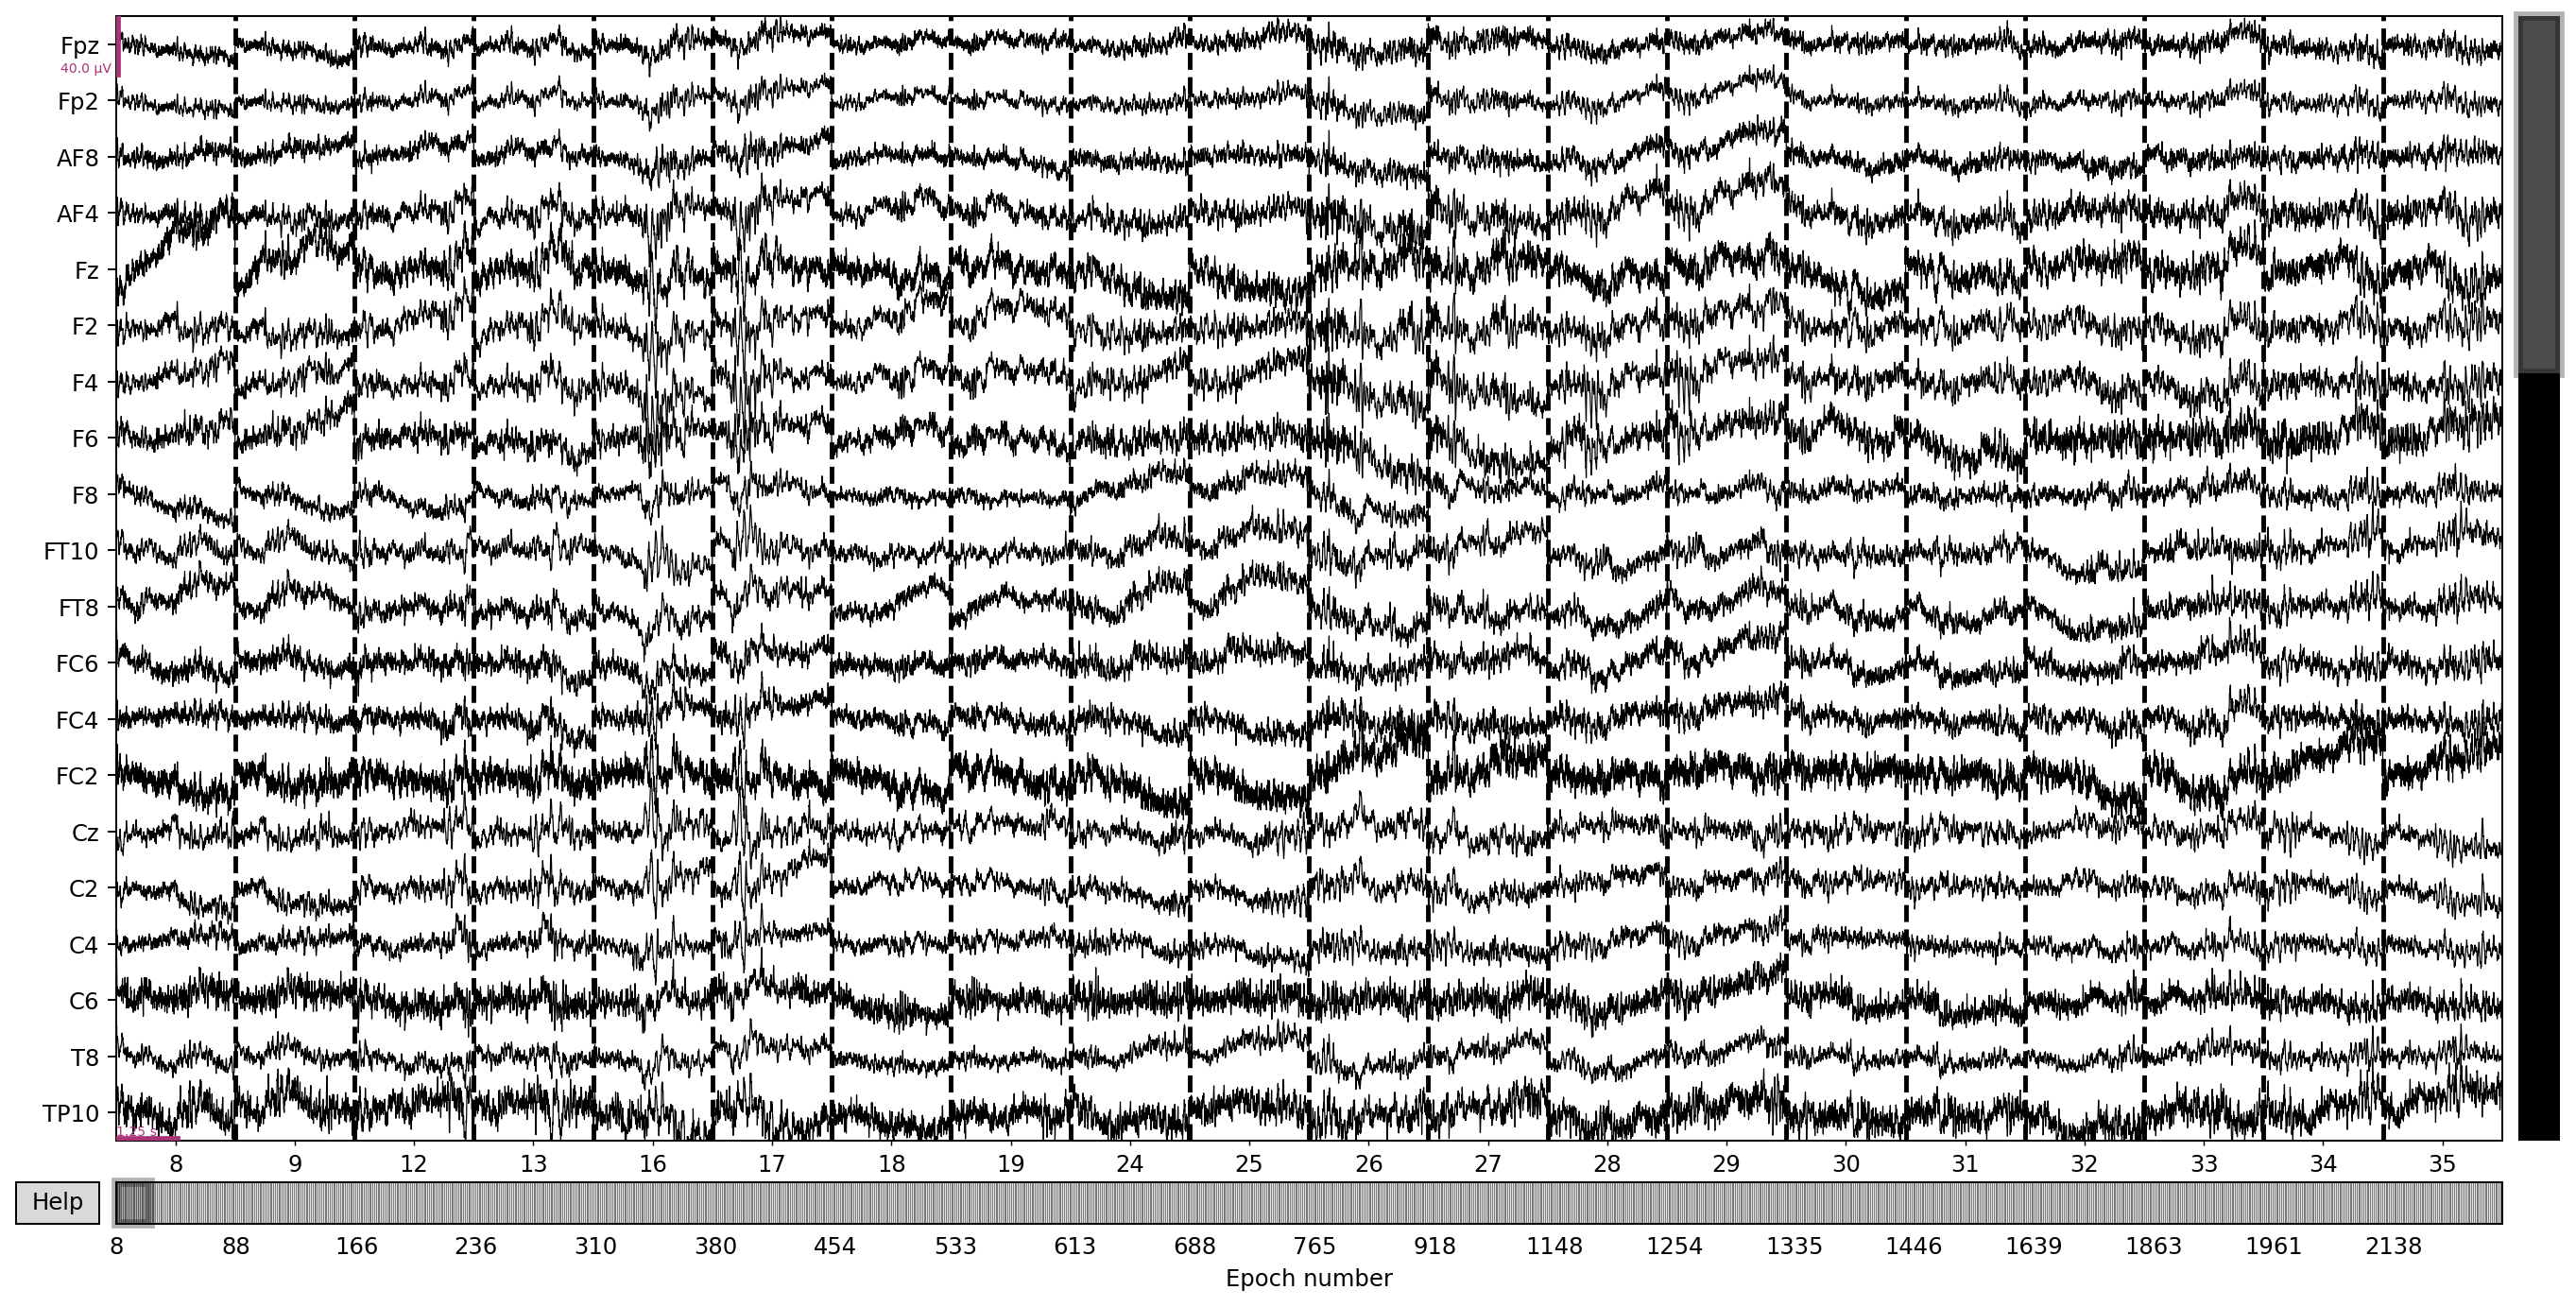

In [19]:
# 剔除肌电、眼电、心电成分
ica.exclude = [0, 1, 5, 6, 10, 12, 14, 16, 19, 25]
ica.apply(epochs)
epochs.plot(show=True)

In [25]:
# 输出预处理后的脑电信号段
output_data_path = r"D:\Documents\EEG\standard-EEG\data\preocessed_epo.fif"
epochs.save(output_data_path, overwrite=True)

[WindowsPath('D:/Documents/EEG/standard-EEG/data/preocessed_epo.fif')]

In [54]:
# 整体脑电 去伪迹 ICA 
ica = ICA(n_components=30,  max_iter='auto')
ica.fit(EEG)
ica.plot_sources(EEG, show=True)
ica.plot_components()

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 1.3s.
Creating RawArray with float64 data, n_channels=30, n_times=97843
    Range : 5657 ... 103499 =     11.314 ...   206.998 secs
Ready.


[<MNEFigure size 1706.25x1692.25 with 20 Axes>,
 <MNEFigure size 1706.25x868 with 10 Axes>]

In [31]:
# ICA 自动寻找肌电
muscle_idx_auto, scores = ica.find_bads_muscle(EEG)
ica.plot_scores(scores, exclude=muscle_idx_auto)  # 输出每一个成分被判断为肌电的分数
print(f"Automatically found muscle artifact ICA components: {muscle_idx_auto}")  # 输出肌电伪迹的成分号

Effective window size : 4.096 (s)
Automatically found muscle artifact ICA components: [2, 3, 4, 7, 8, 9, 12, 16, 17, 18, 19, 28]


In [32]:
ica.plot_properties(EEG, picks=[17, 19])  # 结合自行判断+程序判断，查看对应的肌电成分

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 1225x1050 with 6 Axes>, <Figure size 1225x1050 with 6 Axes>]

In [33]:
# ICA 自动寻找眼电
eog_indices, eog_scores = ica.find_bads_eog(EEG, ch_name='Fpz')  # 设置伪眼电通道 ‘FPz’
print(f"Automatically found eye artifact ICA components: {eog_indices}")

Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)
... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 63 PCA components


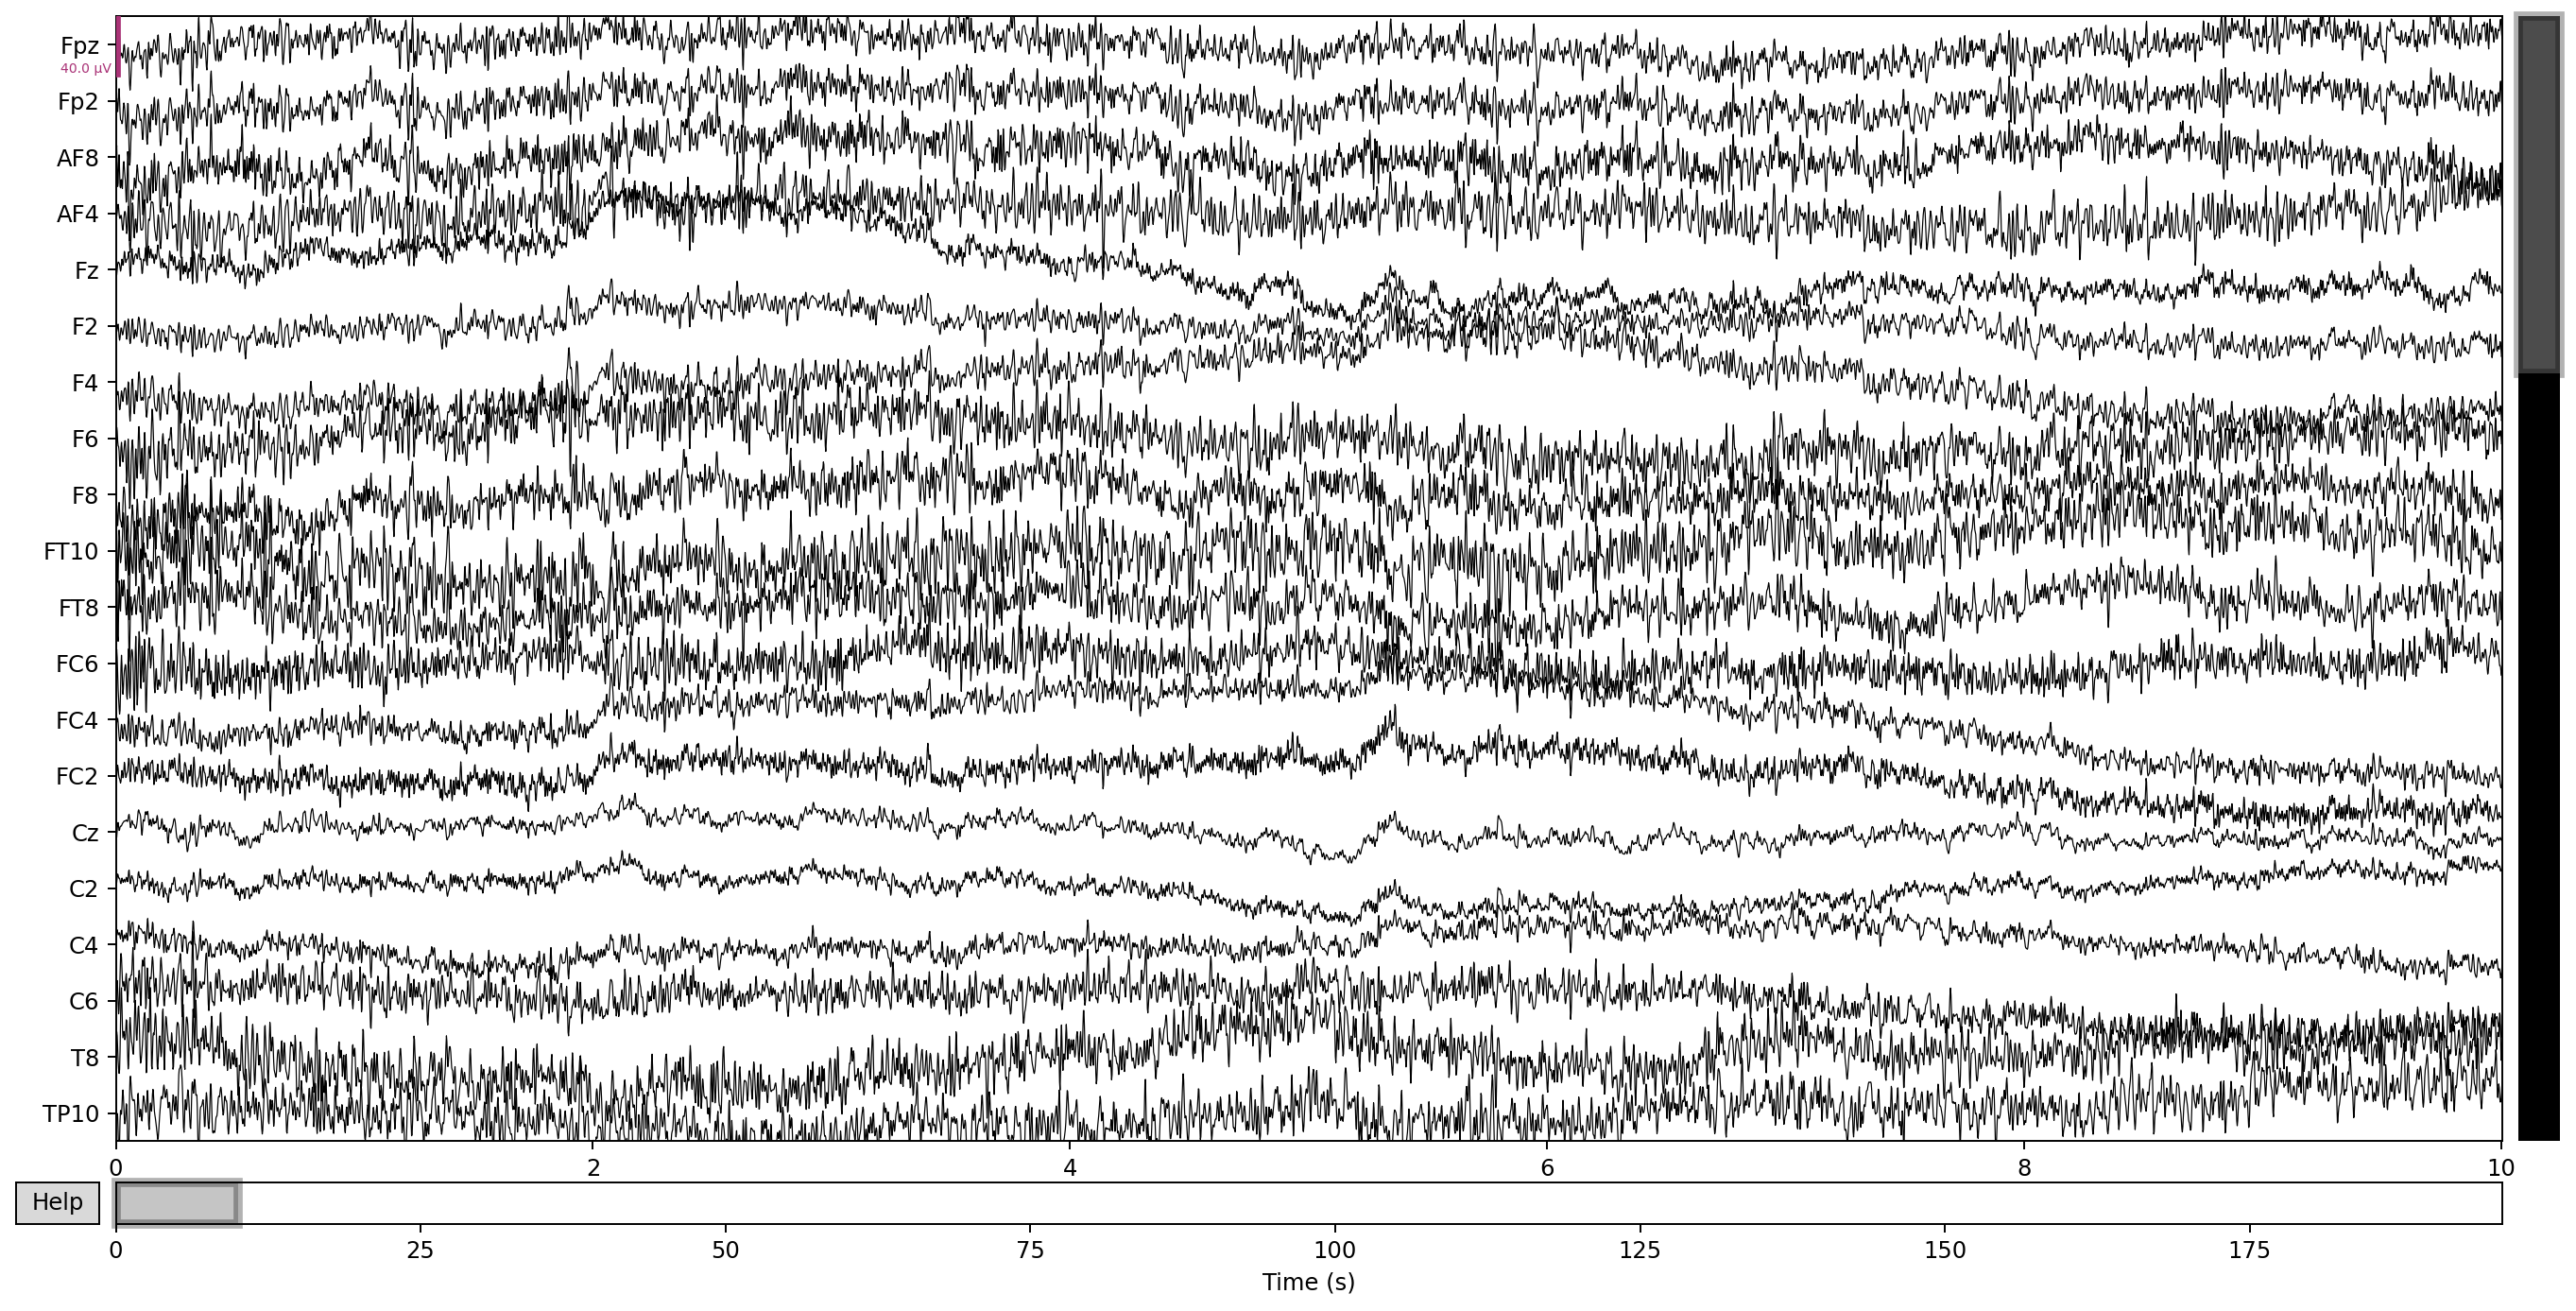

In [35]:
# 剔除肌电、眼电、心电成分
ica.exclude = [1, 6, 17, 19]
ica.apply(EEG)
EEG.plot(show=True)

In [36]:
# 输出预处理后的脑电信号
output_data_path = r"D:\Documents\EEG\standard-EEG\data\preocessed_eeg.fif"
EEG.save(output_data_path)


Writing D:\Documents\EEG\standard-EEG\data\preocessed_eeg.fif
Closing D:\Documents\EEG\standard-EEG\data\preocessed_eeg.fif
[done]


[WindowsPath('D:/Documents/EEG/standard-EEG/data/preocessed_eeg.fif')]